# Initial Exploration of the 311 data 

This file explores the Analyze Boston 311 data to import the data we must first run the import-311-data.py file. This file also loads pandas


In [1]:

import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import numpy as np
import folium # mapping
from folium.plugins import HeatMap
import matplotlib.pyplot as plt # visualization

%matplotlib inline


%run -t import-311-data.py

# clean up some columns 

# convert the closed date to a date time format
df_311['closed_dt'] = pd.to_datetime(df_311['closed_dt'])

df_311['open_dt'] = pd.to_datetime(df_311['open_dt'])

# collapse dates down to month-year
df_311['close_date'] = df_311['closed_dt'].dt.to_period('M')

df_311['open_date'] = df_311['open_dt'].dt.to_period('M')

# create year columns
df_311['close_year'] = df_311['closed_dt'].dt.year

df_311['open_year'] = df_311['open_dt'].dt.year

# convert our closed variable to binary, 1/0
df_311['closed'] = df_311['case_status'].apply(lambda x: 1 if x=='Closed' else 0)

df_311['opened'] = df_311['case_status'].apply(lambda x: 1 if x=='Open' else 0)


/Users/jacobpstein/Documents/Georgetown SCS/capstone/boston-311/02 code/import-311-data.py:24: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(url) for url in urls]
/Users/jacobpstein/Documents/Georgetown SCS/capstone/boston-311/02 code/import-311-data.py:24: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(url) for url in urls]



IPython CPU timings (estimated):
  User   :      18.09 s.
  System :       6.95 s.
Wall time:     192.91 s.


## Structure of the data

Let's take a look at the basic data features

In [118]:
df_311.shape

(2444791, 38)

We can see there are 2.4 million observations across 38 variables.

In [ ]:
df_311.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2444791 entries, 0 to 2444790
Data columns (total 36 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   case_enquiry_id                 int64         
 1   open_dt                         datetime64[ns]
 2   target_dt                       object        
 3   closed_dt                       datetime64[ns]
 4   ontime                          object        
 5   case_status                     object        
 6   closure_reason                  object        
 7   case_title                      object        
 8   subject                         object        
 9   reason                          object        
 10  type                            object        
 11  queue                           object        
 12  department                      object        
 13  submittedphoto                  object        
 14  closedphoto                     object        
 15

Most of our features are text objects, but we have a few integers and floats.

In [119]:
# total unique observations per column
df_311.nunique()

case_enquiry_id                   2444791
open_dt                           2225131
target_dt                         1282251
closed_dt                         2174731
ontime                                  2
case_status                             2
closure_reason                    1811681
case_title                          23828
subject                                14
reason                                 54
type                                  211
queue                                 194
department                             18
submittedphoto                     704064
closedphoto                        363444
location                           146648
fire_district                          12
pwd_district                           22
city_council_district                  11
police_district                        24
neighborhood                           24
neighborhood_services_district         17
ward                                   56
precinct                          

Let's take a look at our numeric varaibles

In [6]:
# notably, we only have a handful of truly numeric values
df_311.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

# 9% of calls remain open


,case_enquiry_id,location_zipcode,latitude,longitude,close_year,open_year,closed,opened
count,2447835.000000,1881590.000000,2447835.000000,2447835.000000,2220553.000000,2447835.000000,2447835.000000,2447835.000000
mean,101002467659.526108,2127.156563,42.331262,-71.079948,2017.500396,2017.537621,0.907150,0.092850
std,1183083.352021,18.499194,0.033656,0.034352,3.074148,3.087275,0.290222,0.290222
min,101000295613.000000,2026.000000,42.230200,-71.185400,2011.000000,2011.000000,0.000000,0.000000
25%,101001529416.500000,2119.000000,42.305600,-71.098900,2015.000000,2015.000000,1.000000,0.000000
50%,101002430820.000000,2126.000000,42.340600,-71.068900,2018.000000,2018.000000,1.000000,0.000000
75%,101003433334.500000,2130.000000,42.359400,-71.058700,2020.000000,2020.000000,1.000000,0.000000
max,101004581318.000000,2467.000000,42.395200,-70.994900,2022.000000,2022.000000,1.000000,1.000000


# Let's visualize the data

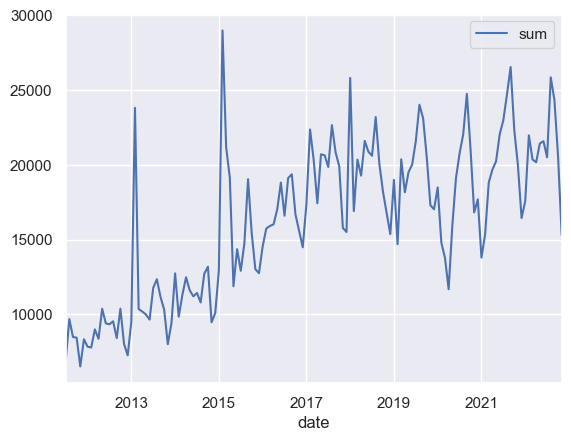

In [2]:
# get the total number of closed calls by month
closed_calls = df_311.groupby(['close_date']).agg({'closed': ['sum']}).reset_index()

# rename the columns
closed_calls.columns = ['date', 'sum']

# set date as the row index
closed_calls = closed_calls.set_index("date")

sns.set_theme(style="darkgrid")

# take a look
closed_calls.plot();

In [3]:
# it looks like there is some clear seasonality in our data

df_311['close_month'] = df_311['closed_dt'].dt.month
close_month = df_311.groupby(['close_month']).agg({'closed': ['sum']}).reset_index()
close_month.columns = ['month', 'sum']

close_month.sort_values('sum', ascending=False)

,month,sum
8,9.0,218809
7,8.0,218707
9,10.0,197009
6,7.0,195245
1,2.0,192216
5,6.0,187645
2,3.0,181711
4,5.0,180220
3,4.0,172589
0,1.0,169557


In [4]:
# let's take a look at the average gap between opening and closing calls

df_311['open_to_close'] = df_311['closed_dt'] - df_311['open_dt']

# convert to days
df_311['open_to_close'] = df_311['open_to_close'].apply(lambda x: x.days)


# average number of days overall
df_311['open_to_close'].describe()


count    2.220619e+06
mean     1.669853e+01
std      7.610968e+01
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.000000e+00
max      2.912000e+03
Name: open_to_close, dtype: float64

In [5]:
# average number of days to close calls by year
df_311.groupby(['close_year'])['open_to_close'].agg('mean')


close_year
2011.0     6.891735
2012.0    14.693035
2013.0    24.652617
2014.0    32.740477
2015.0    24.209018
2016.0    18.506852
2017.0    17.834176
2018.0    17.757748
2019.0    25.347769
2020.0     7.518795
2021.0     6.321454
2022.0     5.922444
Name: open_to_close, dtype: float64

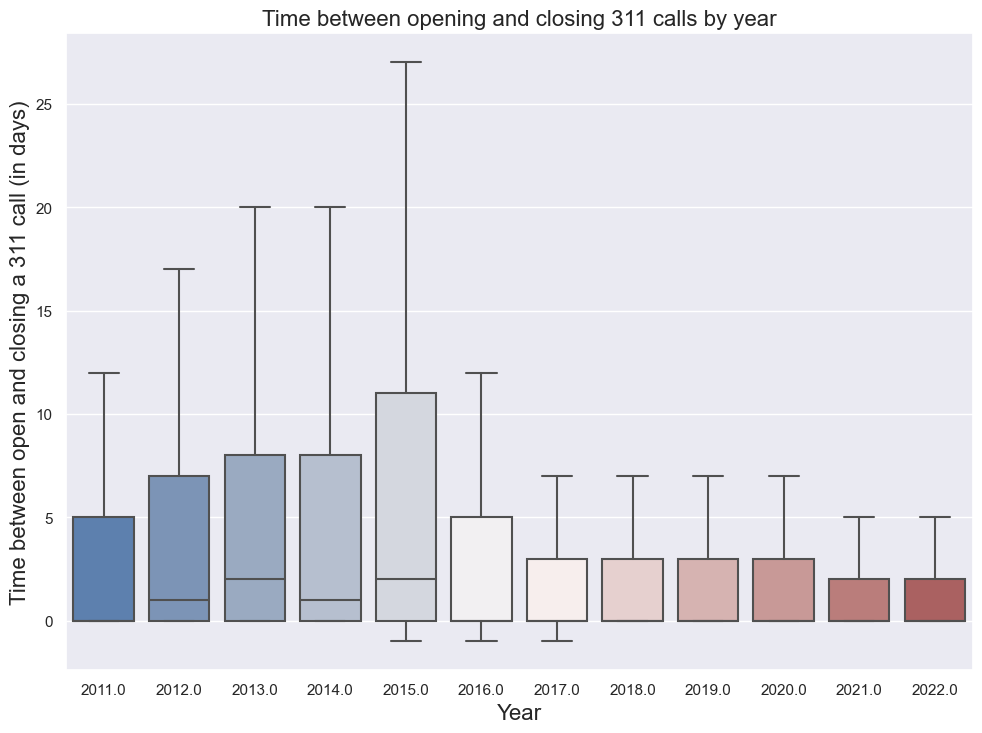

In [6]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

# let's take a look at the time between open and close without outliers

sns.boxplot(data = df_311, y='open_to_close', x='close_year', showfliers = False, palette="vlag")
plt.xlabel('Year', fontsize=16)
plt.ylabel('Time between open and closing a 311 call (in days)', fontsize=16)
plt.title("Time between opening and closing 311 calls by year", size='16');

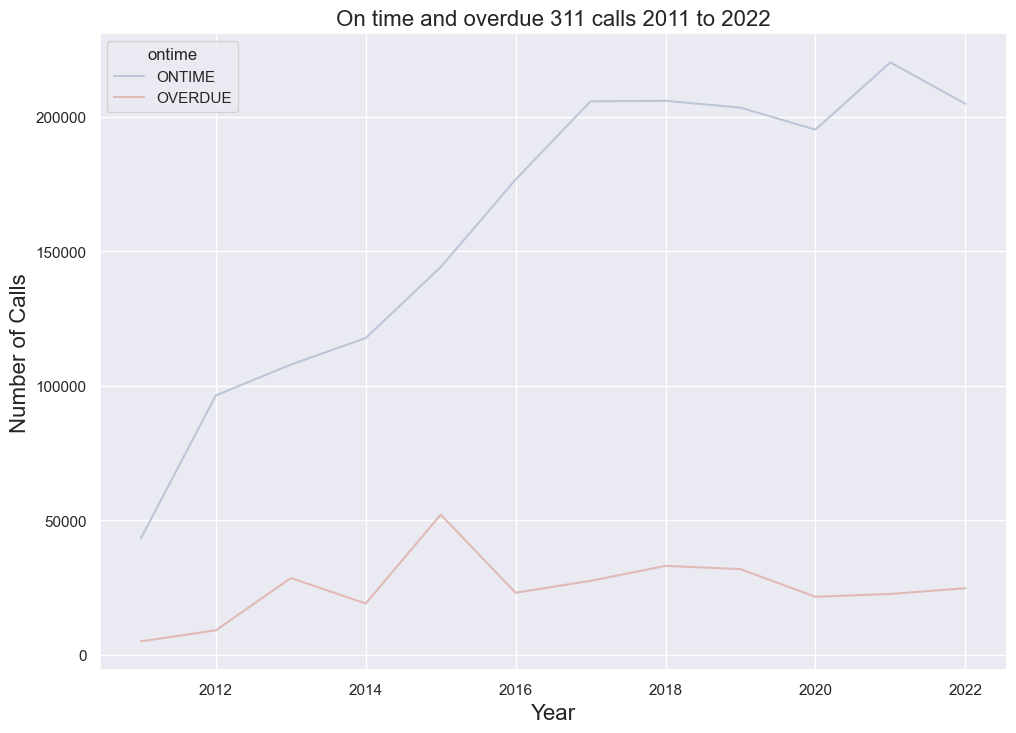

In [7]:
# let's take a look at the ontime and other call related variables

df_311['on_time'] = df_311['ontime'].apply(lambda x: 1 if x=='ONTIME' else 0)


df_ontime  = df_311.groupby("close_year")['ontime'].value_counts(dropna =True).sort_index().reset_index(name="count")  
 
# Setting the Date as index (optional)

# df_solved = df_solved.set_index("Year")

# set a viz theme
sns.set_theme(style="ticks")
sns.set_theme(style="darkgrid")

# plot cases by year
sns.lineplot(x="close_year"
             , y="count"
             , hue="ontime"
             , data=df_ontime
             , palette="vlag")

plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Calls', fontsize=16)
plt.title("On time and overdue 311 calls 2011 to 2022", size='16');

In [13]:
df_311.groupby(['ontime'])['ontime'].count()


ontime
ONTIME     1982395
OVERDUE     461723
Name: ontime, dtype: int64

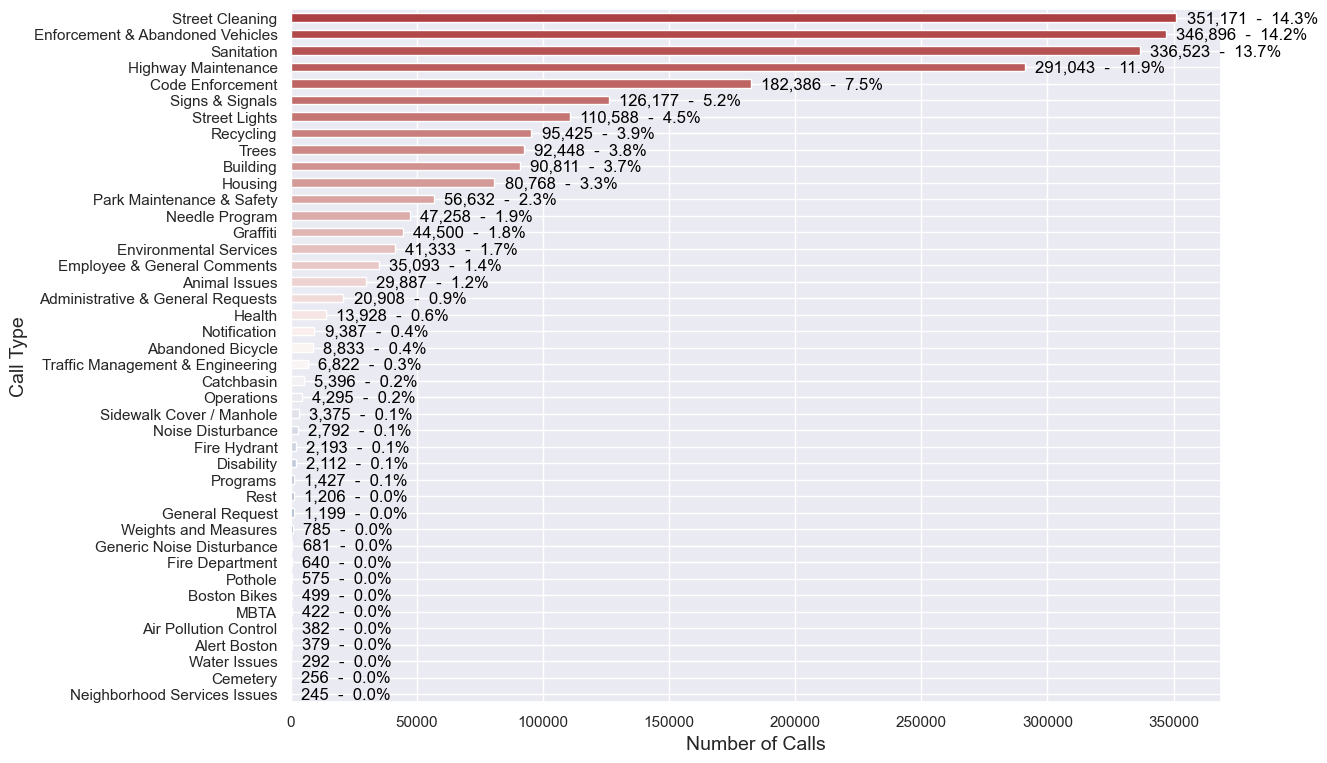

In [8]:
df_new = df_311.copy()

# find the name of the less common complaints and rename all corresponding rows
idx = df_311['reason'].value_counts().sort_values().head(13).index
df_new.loc[df_new['reason'].isin(idx), 'reason'] = 'Rest'

df_reasons = df_new['reason'].value_counts().sort_values()

df_reasons.plot(kind = 'barh', figsize = (12, 9), fontsize = 11, color = sns.color_palette('vlag', len(df_reasons)))
plt.ylabel('Call Type', fontsize = 14)
plt.xlabel('Number of Calls', fontsize = 14)

# Includes the number of incidents and the corresponding percentage for every type
for index, value in enumerate(df_reasons):    
    label = str(format(int(value), ',')) + '  -  {}%'.format(round( (value/df_reasons.sum())*100, 1)) 
    plt.annotate(label, xy = (value + 4000, index - 0.3 ), color = 'black')

/Users/jacobpstein/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3199: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


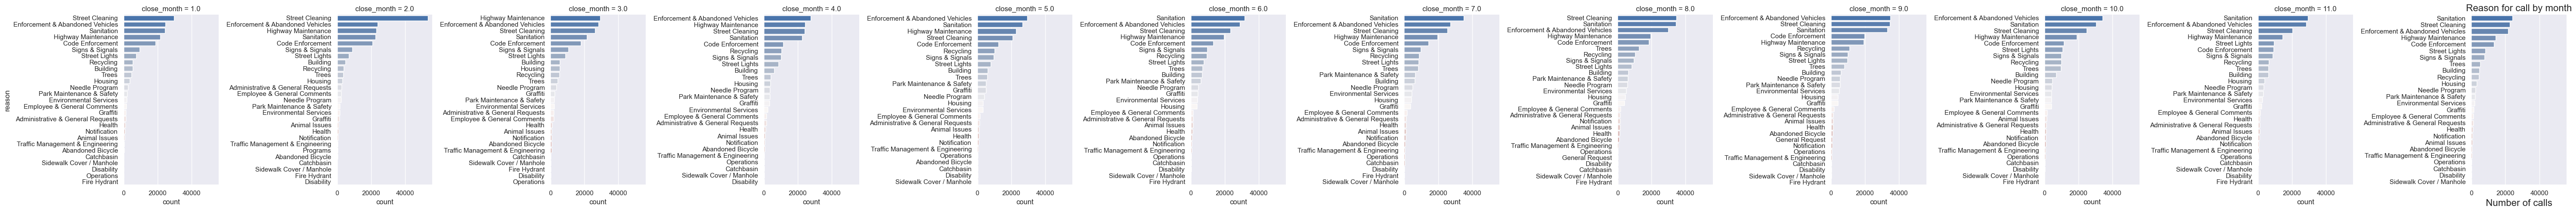

In [15]:
monthly_calls = df_311.groupby("close_month")['reason'].value_counts(dropna =False).sort_index().reset_index(name="count")   


sns.set_theme(style="darkgrid")

sns.catplot(
    data=monthly_calls.loc[monthly_calls['count'] > 100].sort_values(by = 'count', ascending=False), x="count", y="reason", col="close_month",
    kind="bar", sharey = False, palette="vlag"
)
plt.xlabel('Number of calls', fontsize=16)
plt.title("Reason for call by month", size='16');

/Users/jacobpstein/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3199: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


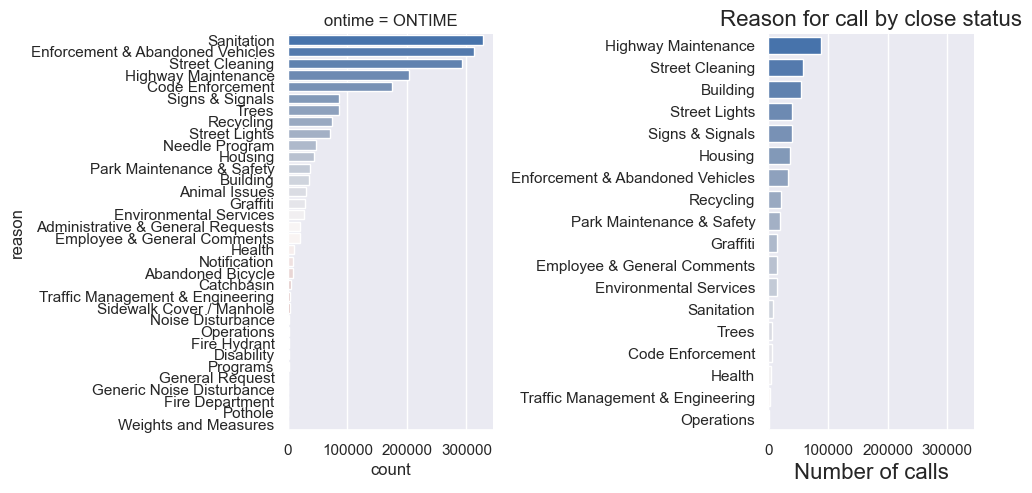

In [112]:
ontime_calls = df_311.groupby("ontime")['reason'].value_counts(dropna =False).sort_index().reset_index(name="count")   

sns.set_theme(style="darkgrid")

sns.catplot(
    data=ontime_calls.loc[ontime_calls['count'] > 500].sort_values(by = 'count', ascending=False), x="count", y="reason", col="ontime",
    kind="bar", sharey = False, palette="vlag"
)

plt.xlabel('Number of calls', fontsize=16)
plt.title("Reason for call by close status", size='16');

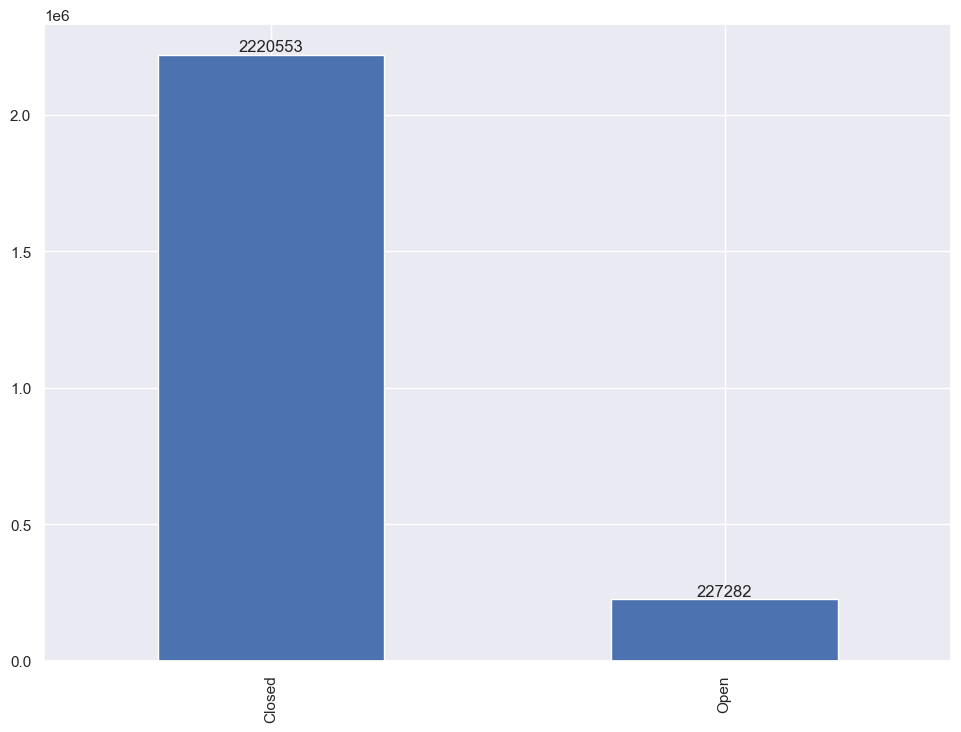

In [16]:
sns.set_theme(style="darkgrid")

status_count_fig = df_311['case_status'].value_counts().plot(kind='bar')
status_count_fig.bar_label(status_count_fig.containers[0], fmt='%d' );



/Users/jacobpstein/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3199: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


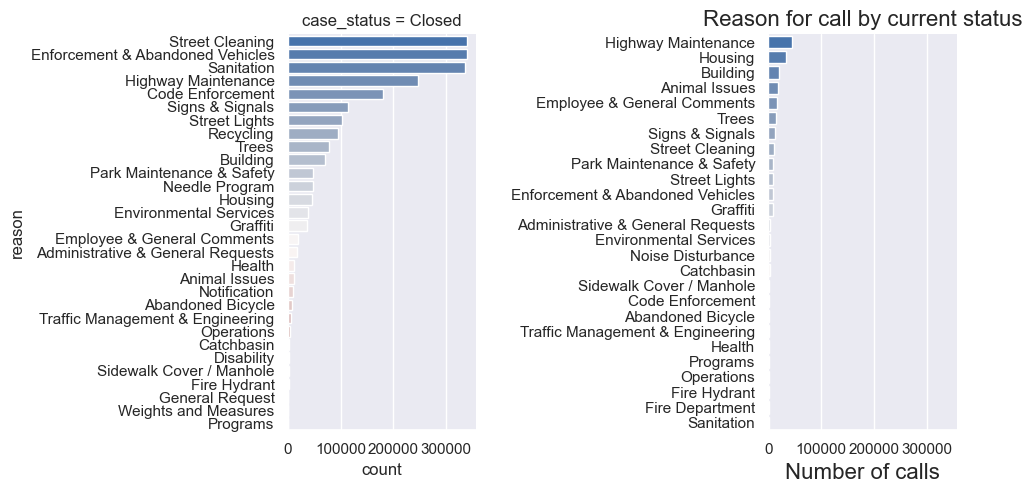

In [17]:
status = df_311.groupby("reason")['case_status'].value_counts(dropna =False).sort_index().reset_index(name="count")   
sns.set_theme(style="darkgrid")

sns.catplot(
    data=status.loc[status['count'] > 500].sort_values(by = 'count', ascending=False), x="count", y="reason", col="case_status",
    kind="bar", sharey = False, palette="vlag"
)

plt.xlabel('Number of calls', fontsize=16)
plt.title("Reason for call by current status", size='16');

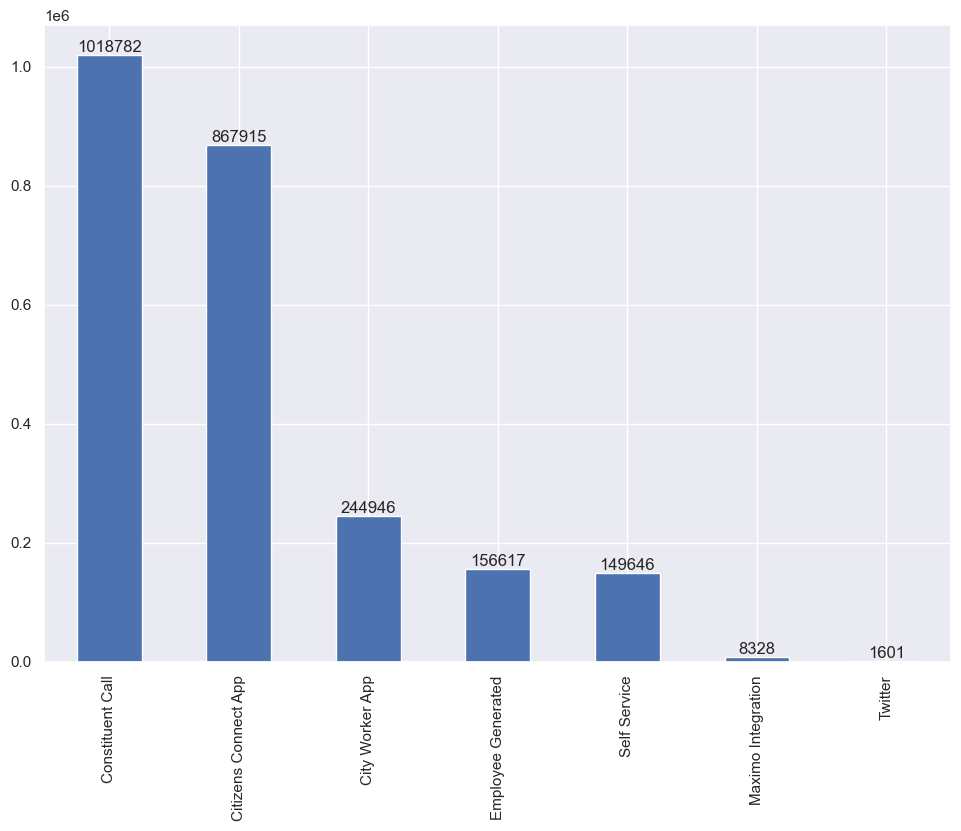

In [18]:
# let's look at where calls came from

sns.set_theme(style="darkgrid")

status_count_fig = df_311['source'].value_counts().plot(kind='bar')
status_count_fig.bar_label(status_count_fig.containers[0], fmt='%d' );


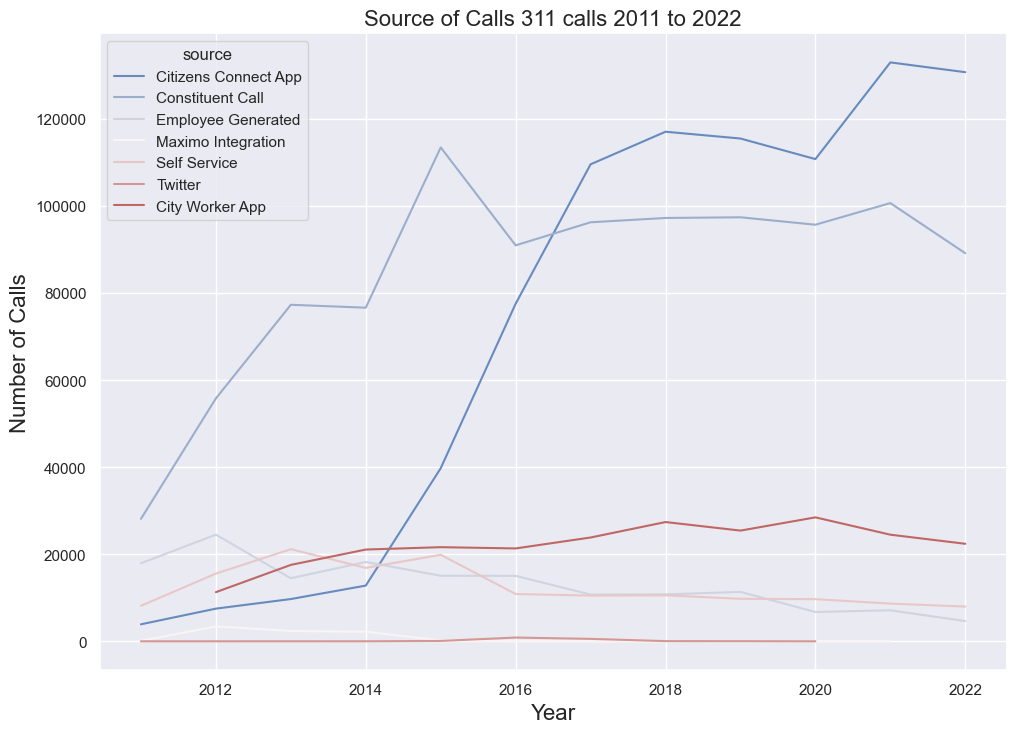

In [19]:
# now let's see how these changed over time


df_source  = df_311.groupby("open_year")['source'].value_counts(dropna =True).sort_index().reset_index(name="count")  

# Setting the Date as index (optional)

df_source = df_source.set_index("open_year")

# set a viz theme
sns.set_theme(style="ticks")
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})


# plot cases by year
sns.lineplot(x="open_year"
             , y="count"
             , hue="source"
             , data=df_source
             , palette="vlag")

plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Calls', fontsize=16)
plt.title("Source of Calls 311 calls 2011 to 2022", size='16');

/Users/jacobpstein/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3199: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


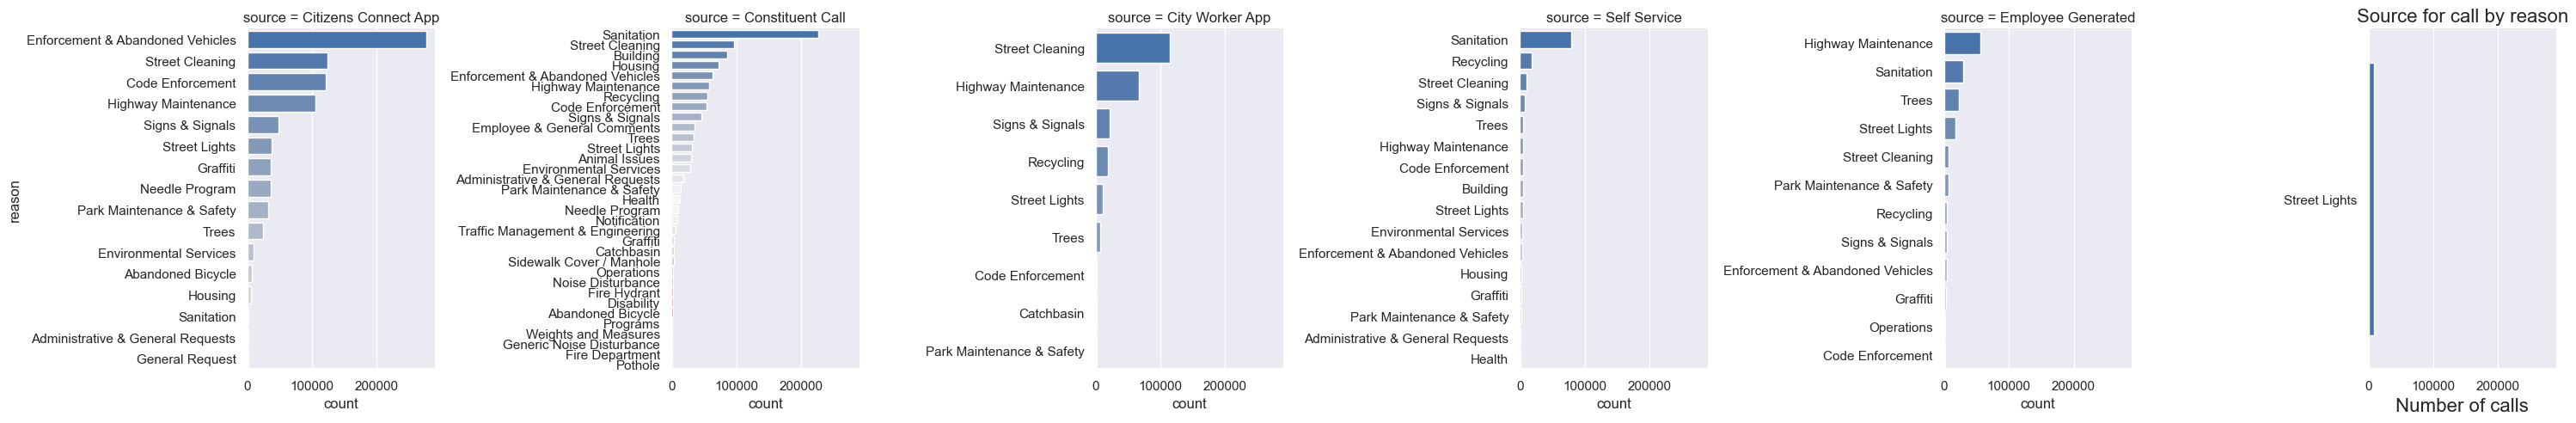

In [20]:
# now let's look at whether certain sources of calls are responsible for different types of calls

source_reason = df_311.groupby("reason")['source'].value_counts(dropna =False).sort_index().reset_index(name="count")   
sns.set_theme(style="darkgrid")

sns.catplot(
    data=source_reason.loc[source_reason['count'] > 500].sort_values(by = 'count', ascending=False), x="count", y="reason", col="source",
    kind="bar", sharey = False, palette="vlag"
)

plt.xlabel('Number of calls', fontsize=16)
plt.title("Source for call by reason", size='16');

# and finally, let's see if how the source and status relate

# now let's look at whether certain sources of calls are responsible for different types of calls

status_source = df_311.groupby("case_status")['source'].value_counts(dropna =False).sort_index().reset_index(name="count") 

sns.set_theme(style="darkgrid")

sns.catplot(
    data=status_source.loc[status_source['count'] > 500].sort_values(by = 'count', ascending=False), x="count", y="case_status", col="source",
    kind="bar", sharey = False, palette="vlag"
)


plt.xlabel('Number of calls', fontsize=16)
plt.title("Source for call by status", size='16')


In [120]:
df_311.head()

,case_enquiry_id,open_dt,target_dt,closed_dt,ontime,case_status,closure_reason,case_title,subject,reason,...,source,close_date,open_date,close_year,open_year,closed,opened,close_month,open_to_close,on_time
0,101000295613,2011-07-01 01:32:33,2011-07-15 01:32:32,2011-07-01 05:06:58,ONTIME,Closed,Case Closed Case Resolved replaced 100 amp fus...,Street Light Outages,Public Works Department,Street Lights,...,Employee Generated,2011-07,2011-07,2011.0,2011,1,0,7.0,0.0,1
1,101000295614,2011-07-01 02:18:31,2011-07-05 02:18:31,2011-07-01 06:12:43,ONTIME,Closed,Case Closed Case Scheduled Items have been sch...,Schedule a Bulk Item Pickup,Public Works Department,Sanitation,...,Self Service,2011-07,2011-07,2011.0,2011,1,0,7.0,0.0,1
2,101000295615,2011-07-01 02:28:04,2011-08-15 02:28:04,2011-08-01 15:21:46,ONTIME,Closed,Case Closed Case Resolved No Sidewalk and poor...,New Sign Crosswalk or Pavement Marking,Transportation - Traffic Division,Signs & Signals,...,Self Service,2011-08,2011-07,2011.0,2011,1,0,8.0,31.0,1
3,101000295616,2011-07-01 03:03:48,2011-07-15 03:03:48,2011-07-22 16:13:45,OVERDUE,Closed,Case Closed Case Resolved completed,Street Light Outages,Public Works Department,Street Lights,...,Self Service,2011-07,2011-07,2011.0,2011,1,0,7.0,21.0,0
4,101000295617,2011-07-01 03:12:31,NaN,2011-07-01 06:12:38,ONTIME,Closed,Case Closed Case Resolved,Highway Maintenance,Public Works Department,Highway Maintenance,...,Constituent Call,2011-07,2011-07,2011.0,2011,1,0,7.0,0.0,1


In [13]:
## Relationships in the data

df_311_total = df_311.groupby(['open_date', 'reason', 'case_status']).size().sort_values(ascending=False).reset_index(name='count')
df_311_total.head()

,open_date,reason,case_status,count
0,2015-02,Street Cleaning,Closed,22091
1,2013-02,Street Cleaning,Closed,17373
2,2015-01,Street Cleaning,Closed,8163
3,2021-09,Enforcement & Abandoned Vehicles,Closed,6483
4,2018-01,Code Enforcement,Closed,6334


In [14]:
# let's encode our dataset to convert all of the many categorical varaibles into binary varaibles
reason_dummies = pd.get_dummies(df_311.reason)
df_311_reason = pd.concat([df_311, reason_dummies], axis=1)

source_dummies = pd.get_dummies(df_311_reason.source)
df_311_source = pd.concat([df_311_reason, source_dummies], axis=1)

# create a numeric data frame
df_311_numeric = df_311_source.select_dtypes(include=np.number)

# let's drop the ids and lat/longs
df_311_numeric_clean = df_311_numeric.drop(['case_enquiry_id', 'latitude', 'longitude'], axis=1)


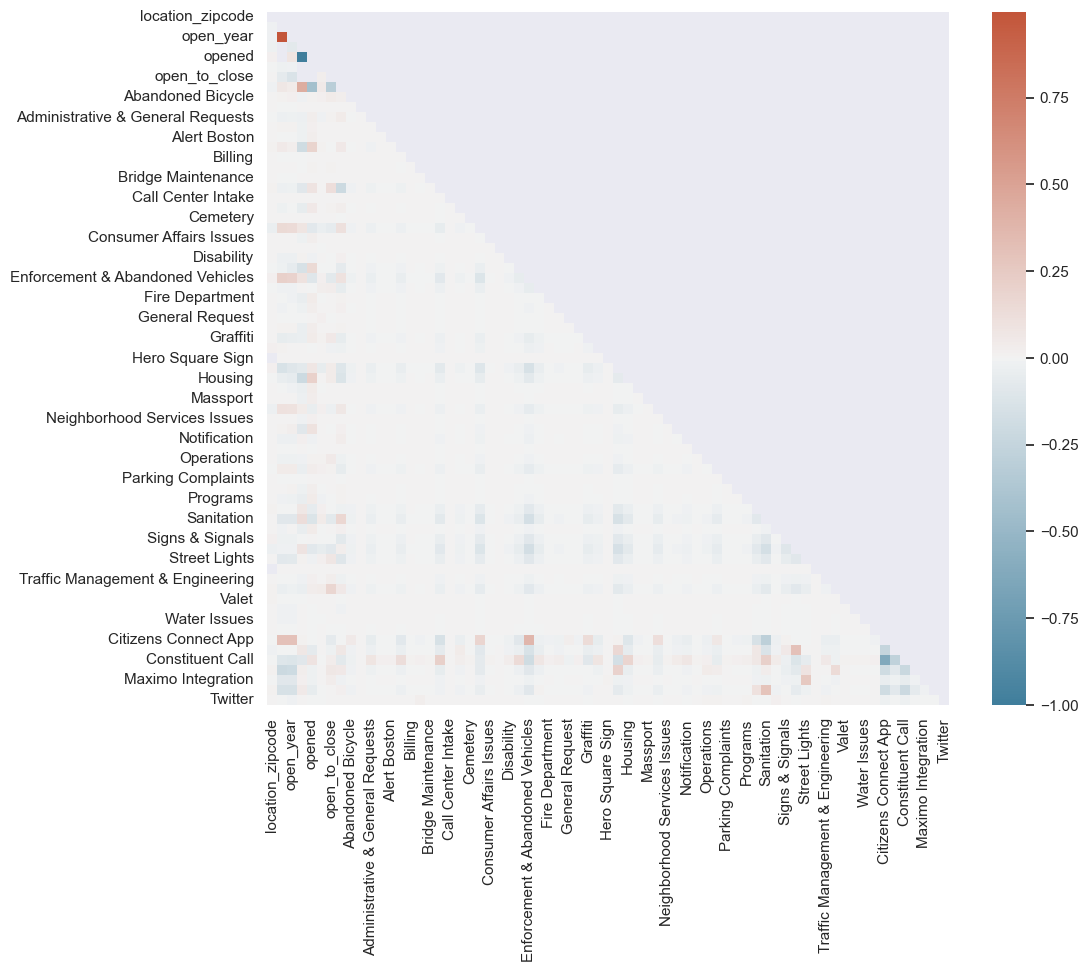

In [15]:
sns.set_theme(style="darkgrid")

# Compute a correlation matrix
corr = df_311_numeric_clean.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=False, mask = mask, cmap=cmap);


Let's look at the above but grouped by zipcode

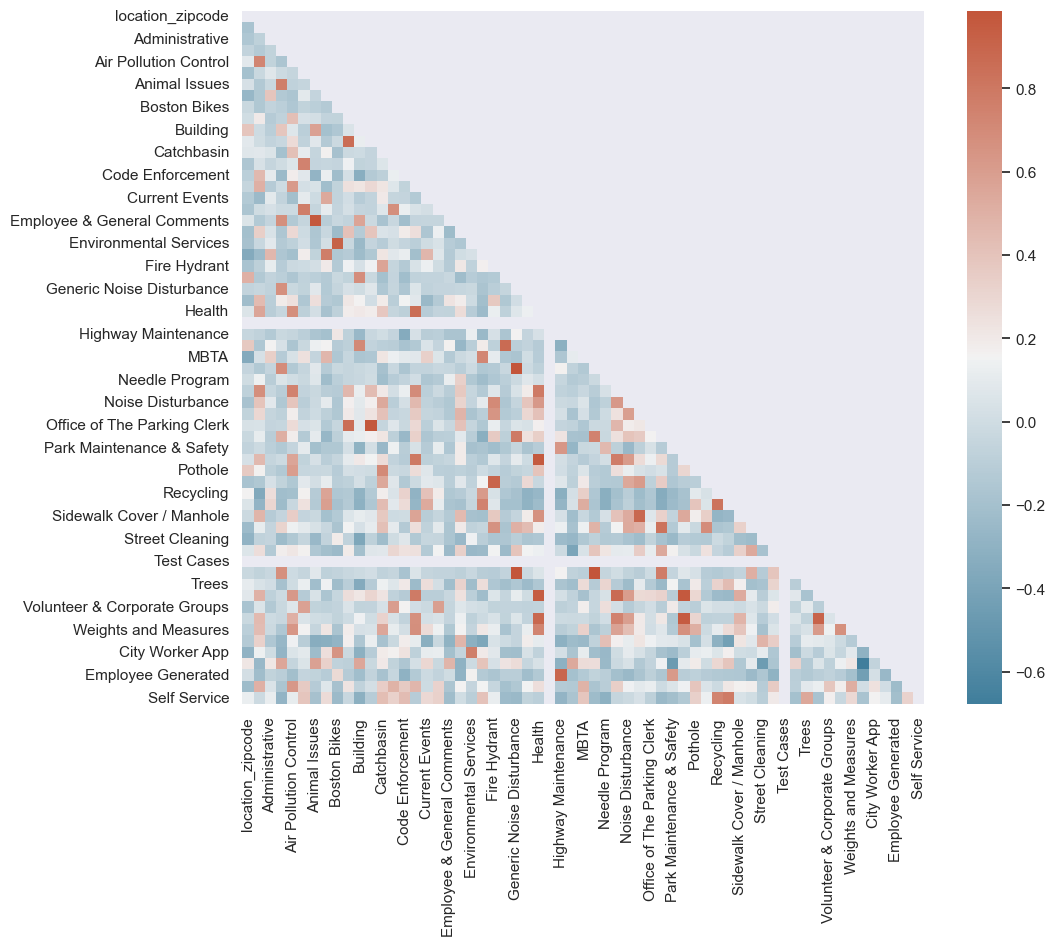

In [29]:

group_df = df_311_numeric_clean.groupby(['location_zipcode'
                                        # , 'close_year' #uncomment to also group by year
                                        # , 'open_year'
                                        ])[df_311_numeric_clean.iloc[:,8:68].columns].mean().reset_index()

sns.set_theme(style="darkgrid")

# Compute a correlation matrix
corr = group_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=False, mask = mask, cmap=cmap);


The above is a lot to take in, let's see it by zip code

/Users/jacobpstein/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/jacobpstein/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


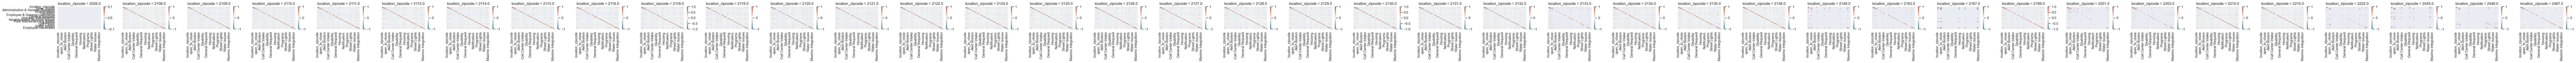

In [35]:
g = sns.FacetGrid(df_311_numeric_clean, col='location_zipcode')
sns.set_theme(style="darkgrid")
g.map_dataframe(lambda data, color: sns.heatmap(data.corr(), linewidths=0, cmap=cmap, annot=False));